## Camera Calibration Matrix and Distortion Coefficients

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

In [4]:
def Cal_undist():
    images = glob.glob('../camera_cal/calibration*.jpg')
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    for image in images:    
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280,720), None, None)
    return mtx, dist

In [5]:
def Undistort(img):
    image = mpimg.imread(img)
    mtx, dist = Cal_undist()
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

In [6]:
def undistort_raw_images():
    images = glob.glob('../camera_cal/calibration*.jpg')
    mtx, dist = Cal_undist()
    for image in images:
        img = Undistort(image)
        mpimg.imsave("../undistorted/" + image.split('\\')[-1], img)

In [11]:
undistort_raw_images()

## PipeLine

In [7]:
def binary_thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [72]:
mpimg.imsave("./examples/binary_threshold.jpg",binary_thresholding(mpimg.imread("../test_images/test3.jpg")), cmap='gray')

## Perspective Transform

In [8]:
def warp(img):
    img_size=(img.shape[1], img.shape[0])
    src = np.float32(
    [[214,717],
    [1096,717],
    [689,451],
    [596,451]])
    
    dst = np.float32(
    [[310,717],
    [880,717],
    [880,10],
    [310,10]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

## Finding lane lines using sliding window approch

In [24]:
def sliding_window(binary_warped, image):   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram  
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]     
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #find radius in real world measurements
    left_curverad, right_curverad = find_radius(lefty, righty, leftx, rightx)
    car_offset = car_position(binary_warped, left_fitx, right_fitx)
    return ploty, left_fitx, right_fitx, car_offset, left_curverad, right_curverad, binary_warped

def plot_lane(ploty, left_fitx, right_fitx, car_offset, left_curverad, right_curverad, binary_warped, Minverse, image):
        
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minverse, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    leftR = "Left Radius - {0:.2f}m".format(left_curverad)
    rightR = "Radius Right - {0:.2f}m".format(right_curverad)
    car_off = "Car_Offset - {0:.2f}m".format(car_offset)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, leftR, (100,100), font, 1 ,(255,255,255), 2)
    cv2.putText(result, rightR, (100,150), font, 1 ,(255,255,255), 2)
    cv2.putText(result, car_off, (100,200), font, 1 ,(255,255,255), 2)
    
    return result

## Radius of Curvature

In [17]:
def find_radius(lefty, righty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 720 * ym_per_pix
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

## Position of Vehicle

In [18]:
# Find car offset from center. The following forum thread helped me with this method
# https://carnd-forums.udacity.com/questions/28147804/how-to-calculate-car-position-relative-to-lane
def car_position(image, left_fitx, right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center = image.shape[1]/2
    left_lane_x = left_fitx[-1]
    right_lane_x = right_fitx[-1]
    lane_center = int((left_lane_x + right_lane_x)/2)
    car_position_px = center - lane_center
    car_position = xm_per_pix * car_position_px
    return car_position

In [19]:
# get inverse perspective matrix
def getMinv(img):    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[214,717],
    [1096,717],
    [689,451],
    [596,451]])
    
    dst = np.float32(
    [[310,717],
    [880,717],
    [880,10],
    [310,10]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)    
    return Minv

In [33]:
def predict_lane(img):    
    binary_image_p = binary_thresholding(img)
    warped_image_p = warp(binary_image_p)
    Mi = getMinv(img)
    ploty, left_fitx, right_fitx, car_offset, left_curverad, right_curverad, binary_warped = sliding_window(warped_image_p, img)
    if ((car_offset > -0.4) & (car_offset < 0.4)):
        global CAR_POSITION
        global LEFT_LANE
        global RIGHT_LANE
        global LEFT_RADIUS
        global RIGHT_RADIUS
        LEFT_LANE = left_fitx
        RIGHT_LANE = right_fitx
        CAR_POSITION = car_offset
        LEFT_RADIUS = left_curverad
        RIGHT_RADIUS = right_curverad
    return plot_lane(ploty, LEFT_LANE, RIGHT_LANE, CAR_POSITION, LEFT_RADIUS, RIGHT_RADIUS, binary_warped, Mi, img)

In [21]:
def pipeline(image):
    result = predict_lane(image)
    return result

/Users/ayaz/Applications/Python2.7_Anaconda/anaconda/envs/sdcnd/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


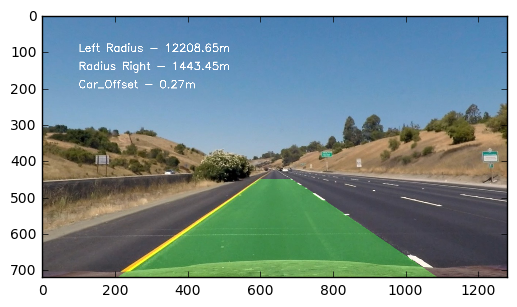

In [25]:
plt.imshow(pipeline(mpimg.imread('./examples/straight_line1.jpg')))

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_output = 'project_video.mp4'
clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/project_video.mp4")
lane_clip = clip1.fl_image(pipeline)
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video project_video.mp4
[MoviePy] Writing video project_video.mp4



100%|█████████▉| 1260/1261 [02:08<00:00, 10.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.mp4 

CPU times: user 3min 49s, sys: 50.6 s, total: 4min 40s
Wall time: 2min 8s
